<a href="https://colab.research.google.com/github/IsaacCorley/deep-aesthetics-pytorch/blob/main/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb 15 00:30:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/IsaacCorley/deep-aesthetics-pytorch.git
%cd deep-aesthetics-pytorch
!ls

Cloning into 'deep-aesthetics-pytorch'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 74 (delta 25), reused 57 (delta 16), pack-reused 0
Unpacking objects: 100% (74/74), done.
/content/deep-aesthetics-pytorch
assets	 LICENSE    requirements.txt  torch_aesthetics	train.py
configs  README.md  scripts	      train.ipynb


In [ ]:
!pip3 install -r requirements.txt
!pip3 install seaborn matplotlib

In [ ]:
!bash scripts/download_aadb.sh

In [58]:
import os
import random
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

import torch_aesthetics
from torch_aesthetics.models import RegressionNetwork
from torch_aesthetics.aadb import AADB, load_transforms

sns.set_theme()

to_pil = T.ToPILImage()

cfg = OmegaConf.load("configs/train.yaml")
model_path = "AADB_epoch_97_loss_0.0710_.pt"
cfg.train.model_path = os.path.join(cfg.train.save_dir, model_path)
cfg.train.model_path

'/content/drive/MyDrive/Github/deep-aesthetics-pytorch/models/AADB_epoch_97_loss_0.0710_.pt'

In [ ]:
model = RegressionNetwork(
        backbone=cfg.models.backbone,
        num_attributes=cfg.data.num_attributes,
        pretrained=cfg.models.pretrained
    )
model = model.to(cfg.device).to(torch.float32)
model.eval()

In [9]:
dataset = AADB(
    image_dir=cfg.data.image_dir,
    labels_dir=cfg.data.labels_dir,
    split="test",
    transforms=load_transforms(input_shape=cfg.data.input_shape)
)
dataloader = DataLoader(
    dataset,
    batch_size=cfg.data.batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=mp.cpu_count(),
    prefetch_factor=cfg.train.num_prefetch
)

In [44]:
loss = 0.0
y_preds = []
with torch.no_grad():
  for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
      x = x.to(cfg.device).to(torch.float32)
      y = y.to(cfg.device).to(torch.float32)
      y_pred = model(x)
      loss += F.mse_loss(y_pred, y)
      y_preds.append(y_pred)

  loss /= len(dataloader)
  y_preds = torch.cat(y_preds, dim=0).cpu().numpy()
  y_preds = np.clip(y_preds, -1.0, 1.0)

  print("\nTest Loss: {:.4f}".format(float(loss)))

100%|██████████| 32/32 [00:02<00:00, 13.90it/s]


Test Loss: 0.5975


In [45]:
y_preds.shape
dataset.labels.shape

(1000, 12)

-1.0 1.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


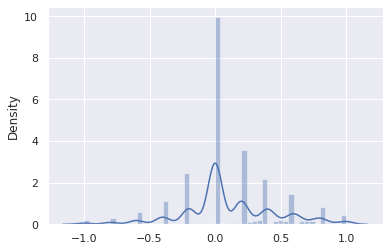

In [47]:
print(dataset.labels.min(), dataset.labels.max())
sns.distplot(dataset.labels)

-1.0 1.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


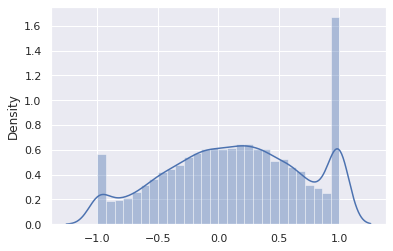

In [48]:
print(y_preds.min(), y_preds.max())
sns.distplot(y_preds)

In [63]:
# States
pos = 0.2
neg = -0.2

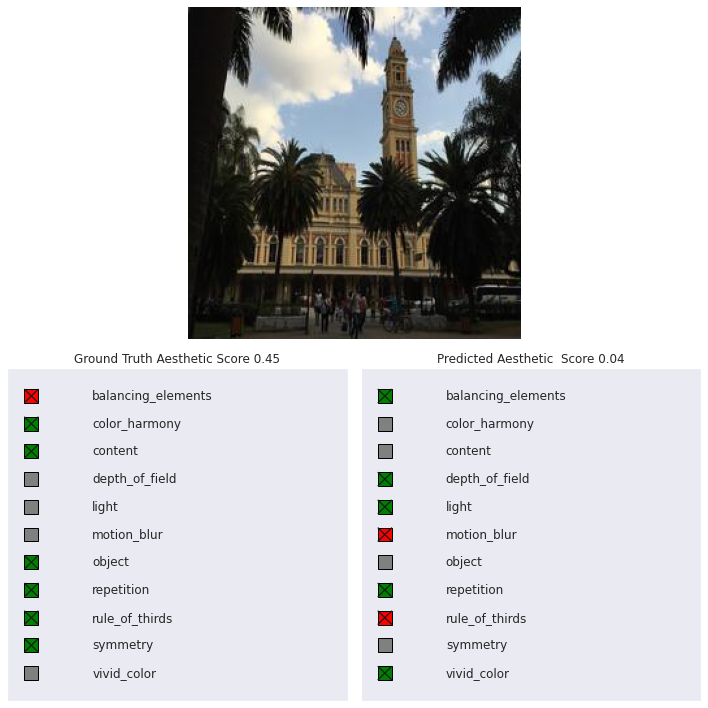

In [112]:
i = random.randint(0, len(dataset))
x, y = dataset[i]
y = y.numpy()
y_pred = y_preds[i]

# Init figure
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

#fig, (ax0, ax1, ax2) = plt.subplots(2, 3, figsize=(17, 5))
ax0.imshow(np.array(to_pil(x)))
ax0.set_axis_off()

### Ground Truth
ax1.set_title("Ground Truth Aesthetic Score {:.2f}".format(y[0]))

# Define check/no check
states = np.zeros_like(y[1:], dtype=bool)
states[y[1:] >= pos] = True
states[y[1:] <= neg] = True

# Display checkboxes
checkboxes_true = mpl.widgets.CheckButtons(ax1, dataset.attributes[1:], actives=states)

# Define checkbox colors
choices = {0: "grey", -1: "red", 1: "green"}
colors = np.zeros_like(y[1:], dtype=int)
colors[y[1:] >= pos] = 1
colors[y[1:] <= neg] = -1
[rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_true.rectangles, colors)]

### Predictions
ax2.set_title("Predicted Aesthetic  Score {:.2f}".format(y_pred[0]))

# Define check/no check
states = np.zeros_like(y_pred[1:], dtype=bool)
states[y_pred[1:] >= pos] = True
states[y_pred[1:] <= neg] = True

# Display checkboxes
checkboxes_pred = mpl.widgets.CheckButtons(ax2, dataset.attributes[1:], actives=states)

# Define checkbox colors
choices = {0: "grey", -1: "red", 1: "green"}
colors = np.zeros_like(y_pred[1:], dtype=int)
colors[y_pred[1:] >= pos] = 1
colors[y_pred[1:] <= neg] = -1
[rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_pred.rectangles, colors)]

# Plot
plt.tight_layout()
plt.show()
